In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Capstone')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pylab

import multiprocessing

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [ ]:
images_path = '/content/drive/MyDrive/Capstone/rsna-pneumonia-detection-challenge.zip'

from zipfile import ZipFile
with ZipFile(images_path,'r') as zip:
  zip.extractall()

In [ ]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 stage_2_detailed_class_info.csv	  stage_2_train_labels.csv
 stage_2_sample_submission.csv


## Exploratory Data Analysis

### Sample Images

In [ ]:
image_sample_path = os.listdir('./stage_2_train_images')[:1]
print(image_sample_path)

['f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm']


In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 8.2 MB/s 


In [ ]:
import pydicom
sample = pydicom.read_file('./stage_2_train_images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm') 
print(sample)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

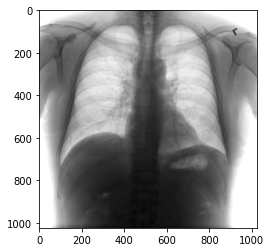

In [ ]:
plt.imshow(sample.pixel_array, cmap=pylab.cm.binary)

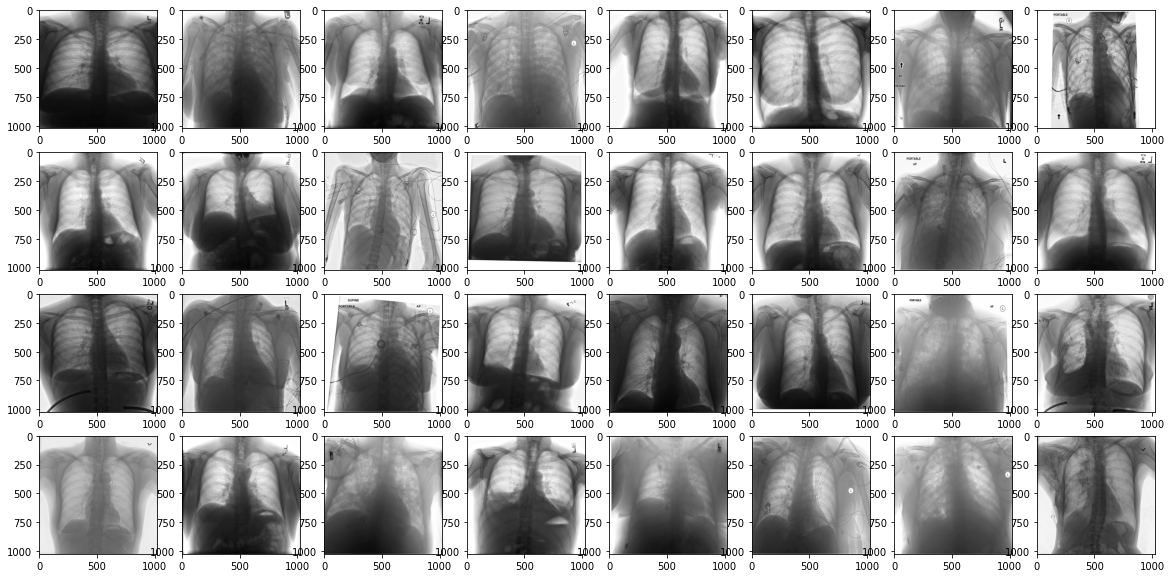

In [ ]:
train_dir = './stage_2_train_images/'
train_images = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]

fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=pylab.cm.binary)
    fig.add_subplot

### Total Number of Images in the Train & Test Set

In [ ]:
train_count = os.listdir('./stage_2_train_images')
test_count = os.listdir('./stage_2_test_images')
print("Number of images in the train set:", len(train_count))
print("Number of images in the test set:", len(test_count))

Number of images in the train set: 26684
Number of images in the test set: 3000


### Class

In [ ]:
class_info = pd.read_csv('stage_2_detailed_class_info.csv')
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

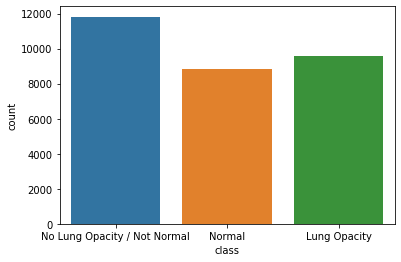

In [ ]:
sns.countplot(class_info['class']);

In [ ]:
class_info.isnull().sum(axis=0)

patientId    0
class        0
dtype: int64

In [ ]:
dup = class_info[class_info.duplicated()].reset_index()
dup.head()

,index,patientId,class
0,5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
1,9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
2,15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
3,17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
4,20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [ ]:
dup['class'].value_counts()

Lung Opacity    3543
Name: class, dtype: int64

### Train Labels

In [ ]:
train_label = pd.read_csv('stage_2_train_labels.csv')
train_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
train_label['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
train_label.count()

patientId    30227
x             9555
y             9555
width         9555
height        9555
Target       30227
dtype: int64

In [ ]:
train_label.duplicated().sum()

0

### Combining Label & Classes into one DataFrame

In [ ]:
combined = train_label.merge(class_info,left_on='patientId', right_on='patientId', how='inner')
combined.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
combined.count()

patientId    37629
x            16957
y            16957
width        16957
height       16957
Target       37629
class        37629
dtype: int64

#### Are the Classes Imbalanced?

In [ ]:
combined.groupby(['class', 'Target']).size().reset_index(name='Total Patient Count')

,class,Target,Total Patient Count
0,Lung Opacity,1,16957
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


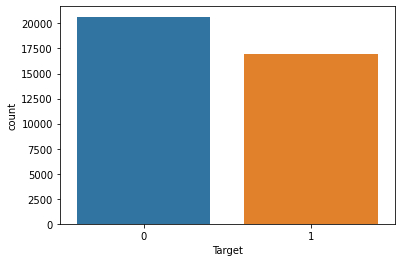

In [ ]:
sns.countplot(combined['Target']);

#### Location of Pneumonia in the Lungs

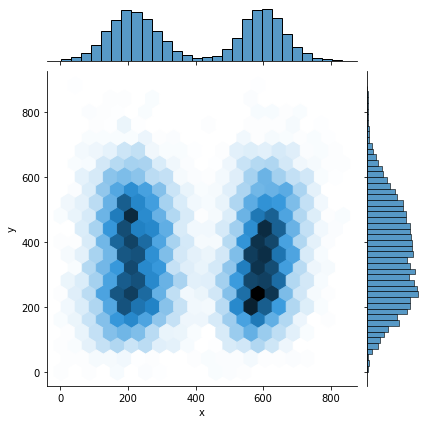

In [ ]:
sns.jointplot(x = 'x', y = 'y', data = combined, kind = 'hex', gridsize = 20);

### Images of each Class

#### Examples for Lung Opacity

In [50]:
lung_opacity = combined.loc[(combined['class'] == 'Lung Opacity' )].reset_index().drop_duplicates(keep='first')
lung_opacity['class'].value_counts()

Lung Opacity    16957
Name: class, dtype: int64

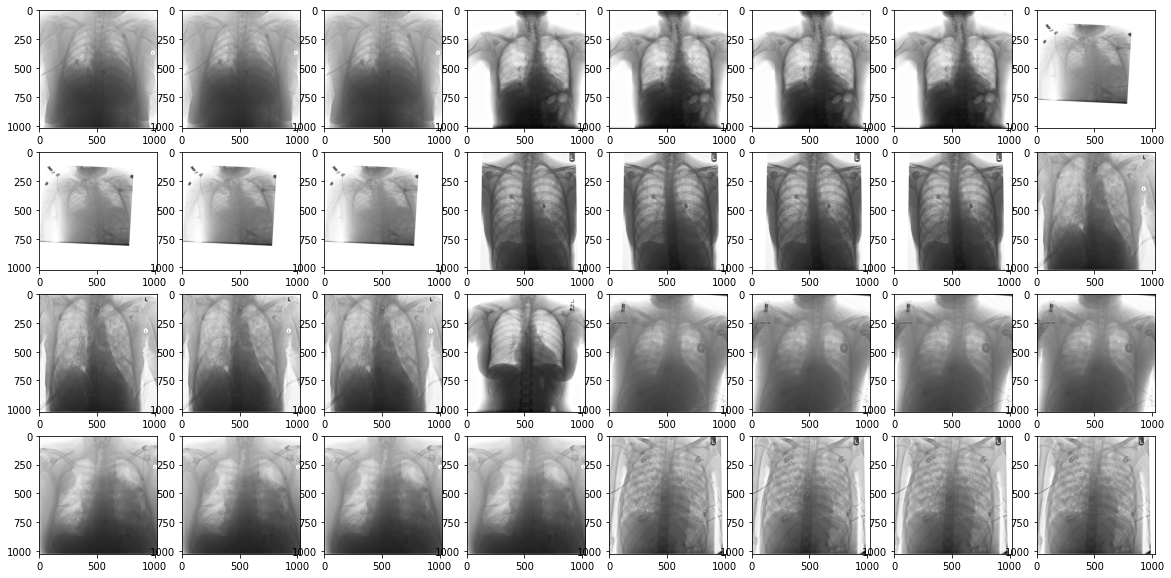

In [51]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = lung_opacity['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### Examples for No Lung Opacity / Not Normal

In [ ]:
not_normal = combined.loc[(combined['class'] == 'No Lung Opacity / Not Normal')].reset_index() 
not_normal['class'].value_counts()

No Lung Opacity / Not Normal    11821
Name: class, dtype: int64

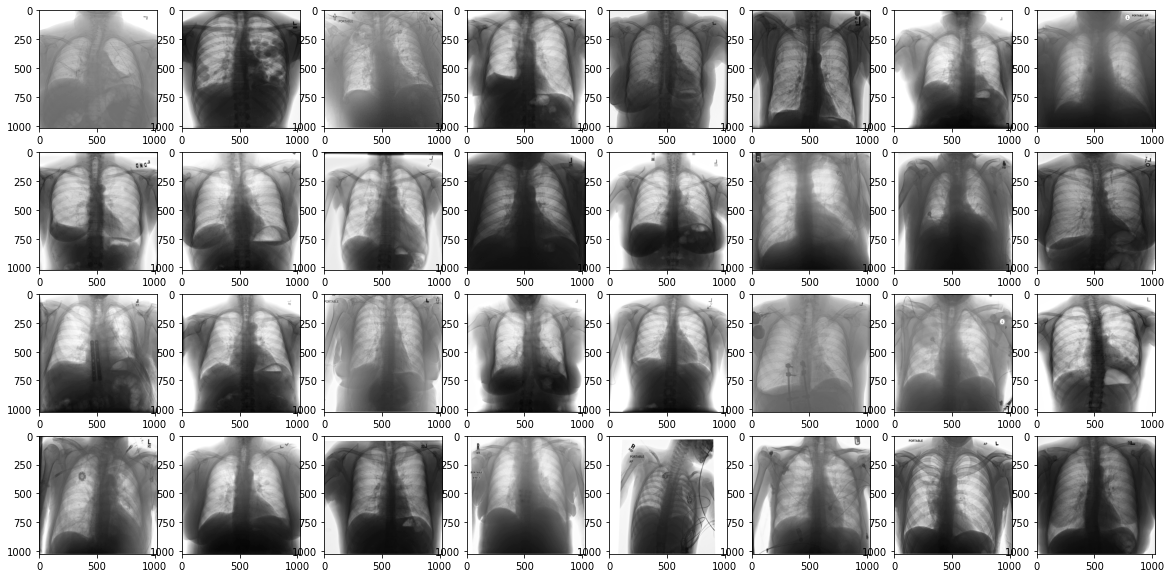

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = not_normal['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### Examples for Normal (No Pneumonia)

In [ ]:
normal = combined.loc[(combined['class'] == 'Normal')].reset_index() 
normal['class'].value_counts()

Normal    8851
Name: class, dtype: int64

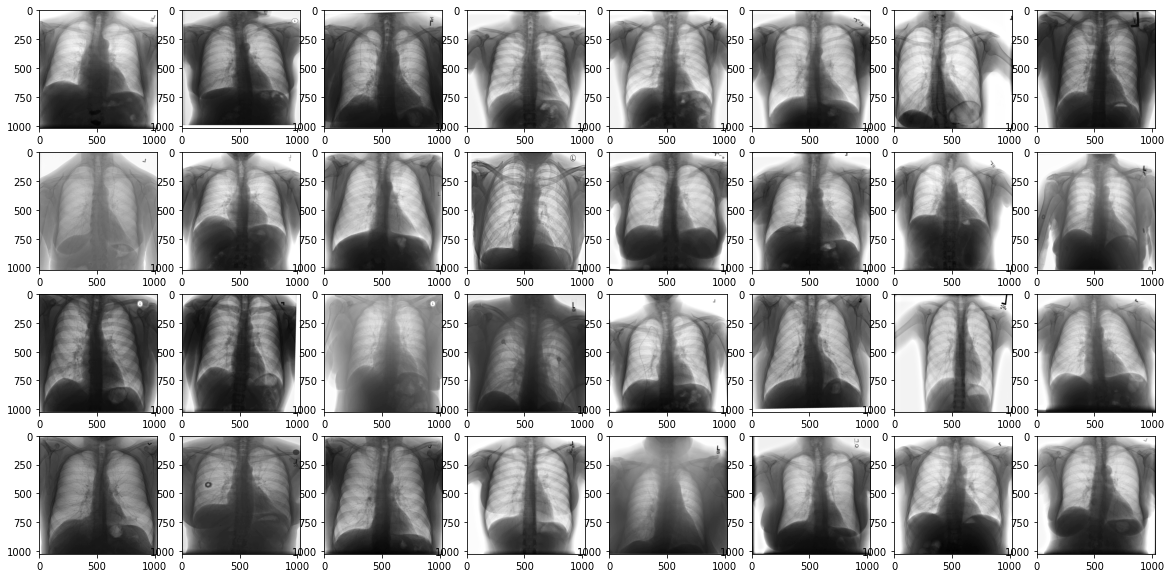

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = normal['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### Side by Side Comparison of all three Classes

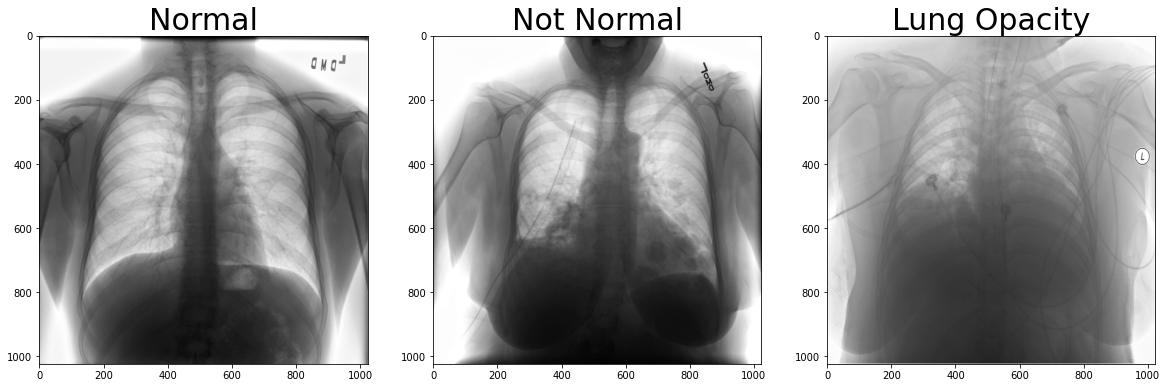

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1

fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = normal['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = not_normal['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 3).set_title("Lung Opacity", fontsize=30)
train_dir = './stage_2_train_images/'
filename = lung_opacity['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

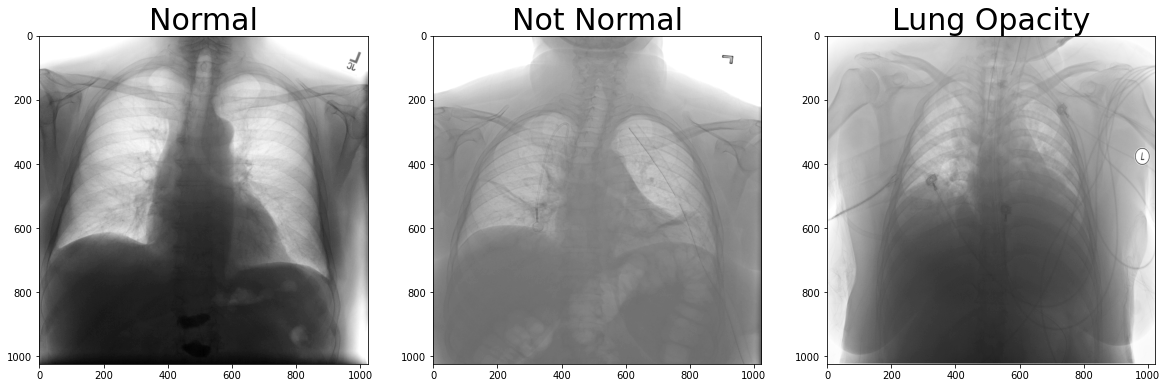

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1

fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = normal['patientId'][1] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = not_normal['patientId'][1] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 3).set_title("Lung Opacity", fontsize=30)
train_dir = './stage_2_train_images/'
filename = lung_opacity['patientId'][1] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

### Metadata for all Training Images

In [ ]:
sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [ ]:
def get_info(patientId, root_dir='./stage_2_train_images/'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return {'age': dcm_data.PatientAge, 
            'gender': dcm_data.PatientSex,
            'modality': dcm_data.Modality, 
            'id': os.path.basename(fn).split('.')[0]
            }

ids = list(train_label['patientId'].unique())

In [ ]:
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, ids)

In [ ]:
metadata = pd.DataFrame(result)
metadata['age'] = metadata['age'].astype(int)
metadata['gender'] = metadata['gender'].astype('category')

In [ ]:
combined = (combined.merge(metadata, left_on='patientId', right_on='id', how='left').drop(columns='id'))

combined.head()

,patientId,x,y,width,height,Target,class,age,gender,modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F,CR


#### Age Distribution between Gender and Target

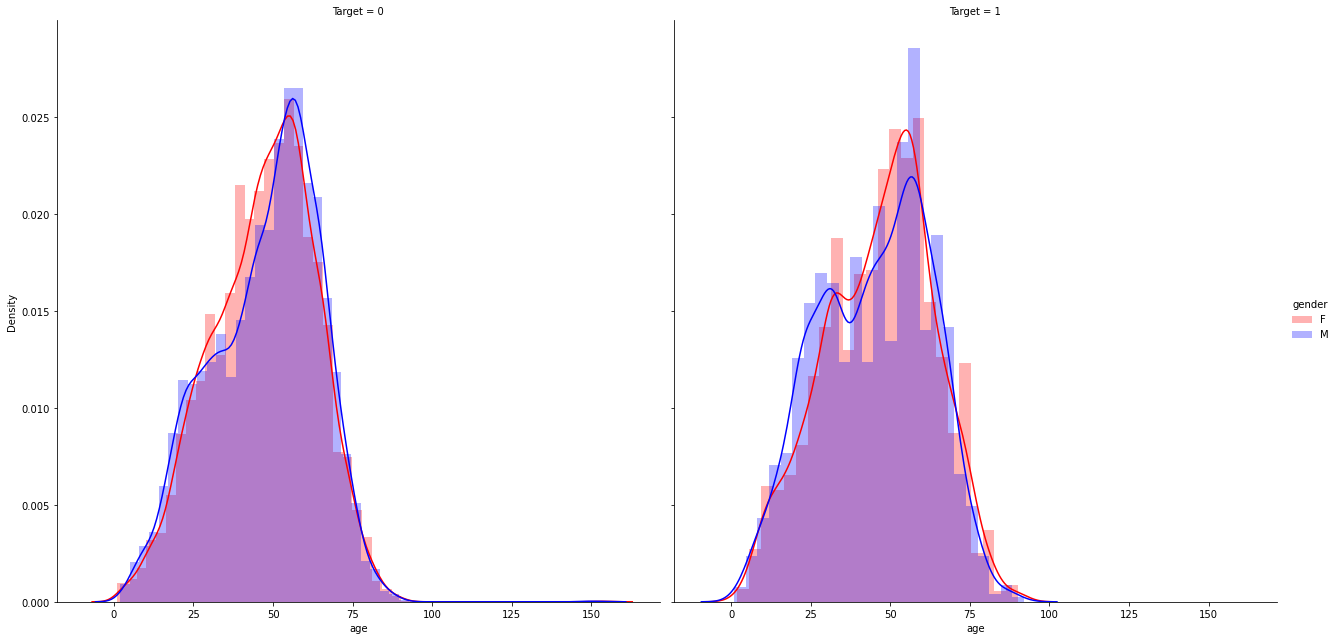

In [ ]:
g = sns.FacetGrid(col='Target', hue='gender', 
                  data=combined.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
g.map(sns.distplot, 'age', hist_kws={'alpha': 0.3}).add_legend()

#### Statistical Analysis of the data

In [ ]:
combined.describe()

,x,y,width,height,Target,age
count,16957.000000,16957.000000,16957.000000,16957.000000,37629.000000,37629.000000
mean,398.980008,360.443121,219.266675,337.799552,0.450636,46.482394
std,204.869392,149.202409,59.195268,158.986899,0.497564,17.008911
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,209.000000,243.000000,178.000000,210.000000,0.000000,33.000000
50%,343.000000,355.000000,218.000000,309.000000,0.000000,48.000000
75%,596.000000,472.000000,259.000000,452.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [ ]:
combined.corr()

,x,y,width,height,Target,age
x,1.000000,0.021598,-0.069520,-0.007830,NaN,-0.010099
y,0.021598,1.000000,-0.296784,-0.641857,NaN,0.100815
width,-0.069520,-0.296784,1.000000,0.605735,NaN,0.026475
height,-0.007830,-0.641857,0.605735,1.000000,NaN,-0.007733
Target,NaN,NaN,NaN,NaN,1.000000,-0.062877
age,-0.010099,0.100815,0.026475,-0.007733,-0.062877,1.000000


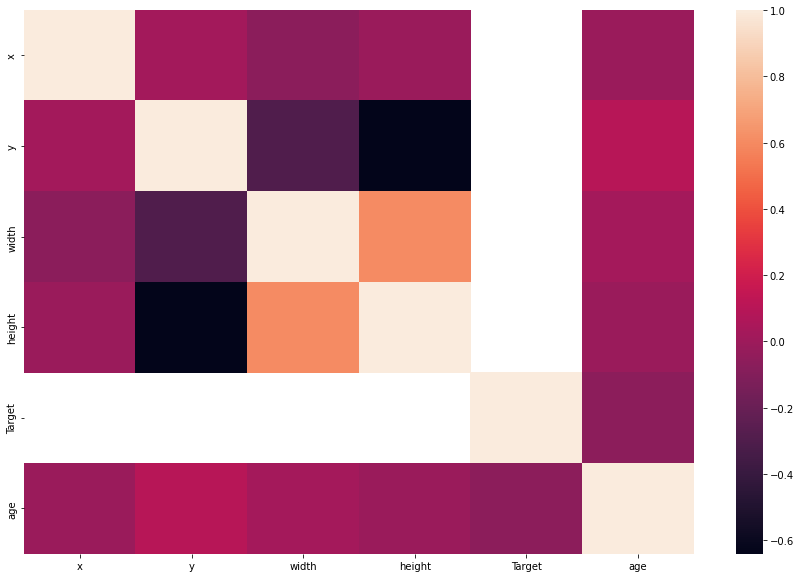

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(combined.corr())

#### Outliers?

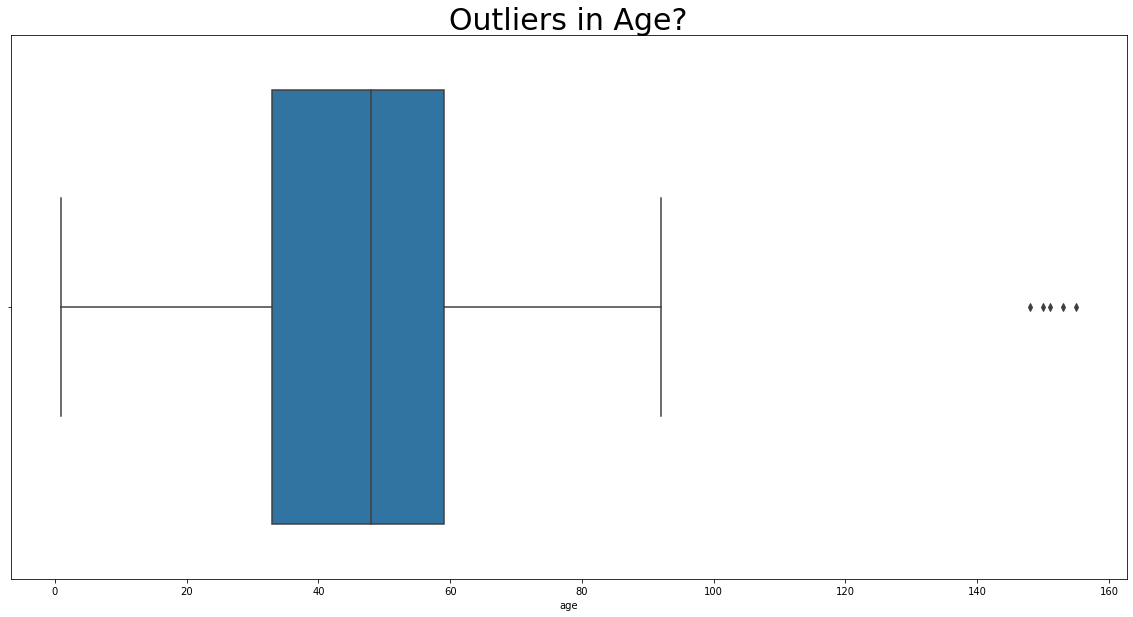

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 1; rows = 1

fig.add_subplot(rows, columns, 1).set_title("Outliers in Age?", fontsize=30)
sns.boxplot(combined['age'])

In [ ]:
combined.loc[(combined['age'] >= 100)]

,patientId,x,y,width,height,Target,class,age,gender,modality
5525,3b8b8777-a1f6-4384-872a-28b95f59bf0d,NaN,NaN,NaN,NaN,0,Normal,148,M,CR
13818,73aeea88-fc48-4030-8564-0a9d7fdecac4,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,151,F,CR
21301,a4e8e96d-93a6-4251-b617-91382e610fab,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,153,M,CR
32970,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,NaN,NaN,NaN,NaN,0,Normal,150,M,CR
34436,f632328d-5819-4b29-b54f-adf4934bbee6,NaN,NaN,NaN,NaN,0,Normal,155,F,CR
